Using device: cuda
Found 2 classes.
Dataset sizes: {'train': 7000, 'val': 1500, 'test': 1500}
Class names: ['kidney_normal', 'kidney_tumor']
Pre-trained weights loaded successfully from file.
\nEpoch 0/49\n----------
Train Loss: 0.4127 Acc: 0.8347
Val Loss: 0.2501 Acc: 0.9347
Best validation accuracy! Model saved.
\nEpoch 1/49\n----------
Train Loss: 0.2853 Acc: 0.8913
Val Loss: 0.2020 Acc: 0.9440
Best validation accuracy! Model saved.
\nEpoch 2/49\n----------
Train Loss: 0.2589 Acc: 0.8973
Val Loss: 0.1699 Acc: 0.9507
Best validation accuracy! Model saved.
\nEpoch 3/49\n----------
Train Loss: 0.2486 Acc: 0.9010
Val Loss: 0.1545 Acc: 0.9587
Best validation accuracy! Model saved.
\nEpoch 4/49\n----------
Train Loss: 0.2282 Acc: 0.9100
Val Loss: 0.1543 Acc: 0.9500
\nEpoch 5/49\n----------
Train Loss: 0.2248 Acc: 0.9139
Val Loss: 0.1337 Acc: 0.9640
Best validation accuracy! Model saved.
\nEpoch 6/49\n----------
Train Loss: 0.2284 Acc: 0.9081
Val Loss: 0.1318 Acc: 0.9600
\nEpoch 7/49\n----

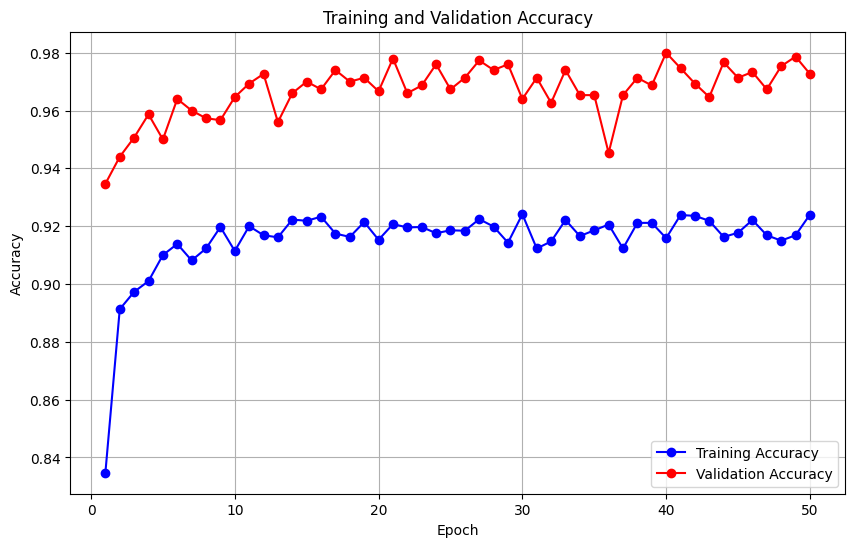

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# --- 1. Configuration and Hyperparameters ---
DATA_DIR = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Kidney Cancer"
MODEL_PATH = "/kaggle/input/mobilenet1/pytorch/default/1/mobilenet_v2-7ebf99e0.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

try:
    NUM_CLASSES = len(os.listdir(DATA_DIR))
    print(f"Found {NUM_CLASSES} classes.")
except FileNotFoundError:
    print(f"FATAL ERROR: The directory '{DATA_DIR}' was not found. Please check your dataset path.")
    exit()

# --- 2. Data Preprocessing and Loading ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes

total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

class CustomDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = CustomDataset(train_subset, transform=train_transforms)
val_dataset = CustomDataset(val_subset, transform=val_test_transforms)
test_dataset = CustomDataset(test_subset, transform=val_test_transforms)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# --- 3. Model Definition ---
model = models.mobilenet_v2(weights=None)
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Pre-trained weights loaded successfully from file.")
except Exception as e:
    print(f"Could not load weights from {MODEL_PATH}. Error: {e}. Training from scratch.")

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, NUM_CLASSES)
)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

# --- 4. Training Function ---
def train_model(model, criterion, optimizer, dataloaders, num_epochs):
    since = time.time()
    best_acc = 0.0
    train_acc_history, val_acc_history = [], []
    best_model_path = "/kaggle/working/best_model_weights.pth"

    for epoch in range(num_epochs):
        print(f'\\nEpoch {epoch}/{num_epochs - 1}' + '\\n' + '-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            (train_acc_history if phase == 'train' else val_acc_history).append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_path)
                print("Best validation accuracy! Model saved.")
    time_elapsed = time.time() - since
    print(f'\\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    return model, train_acc_history, val_acc_history, best_model_path

# --- 5. Evaluation Function ---
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    test_time = time.time() - start_time
    print(f"\\nTesting complete in {test_time:.2f}s")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    try:
        if NUM_CLASSES == 2:
            auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
        else:
            auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
    except ValueError:
        auc = 0.0
    print("\\n--- Evaluation Metrics ---")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    return test_time

# --- 6. Main Execution ---
if __name__ == '__main__':
    model, train_acc, val_acc, best_model_path = train_model(model, criterion, optimizer, dataloaders, num_epochs=NUM_EPOCHS)
    print("\\n--- Loading best model for evaluation ---")
    model.load_state_dict(torch.load(best_model_path))
    print("\\n--- Evaluating on Test Set ---")
    test_time = evaluate_model(model, dataloaders['test'], class_names)
    print("\\n--- Generating Accuracy Plot ---")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, NUM_EPOCHS + 1), train_acc, 'b-o', label='Training Accuracy')
    plt.plot(range(1, NUM_EPOCHS + 1), val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()